# Gaussian Process Regression

This notebook, I will go over how we can implement the Gaussian process (GP) regression algorithm using Jax. This isn't a new algorithm or anything but I would like to get accustomed to using Jax because it will be useful later when I implement the GPs to handle uncertain inputs.

**Inspirations**

* [Github Code](https://github.com/lucasrm25/Structured-Learning-for-Robot-Control/blob/master/GP/jaxGP.py) - [Lucas](https://www.linkedin.com/in/lucas-rath/?originalSubdomain=bo)
> Broke down the GP function very nicely. Nice enough for me to follow.

## Imports

In [1]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
import numpy as np
import numpy as onp

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

## Data

In [2]:
def get_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.2, 1.2, N_test)

    return X[:, None], Y[:, None], X_test[:, None], None

(30, 1) (30, 1)


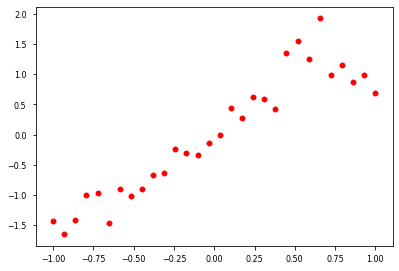

In [4]:
logger.setLevel(logging.INFO)
, y, Xtest, ytest = get_data()
print(X.shape, y.shape)

fig, ax = plt.subplots()
ax.scatter(X, y, c='red')
plt.show()

## Gaussian Process

## Model: GP Prior

**Parameters**:

* X, Y, $\theta= $ (Likelihood Parameters, Kernel Parameters)

1. Compute the Kernel Matrix
2. Compute the Mean function
3. Sample from the Multivariate Normal Distribution

### Kernel Function

$$k(x,y) = \sigma_f \exp \left( - \frac{1}{2\sigma_\lambda^2}|| x - y||^2_2 \right)$$

In [5]:
# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    return jnp.exp( - params['gamma'] * sqeuclidean_distance(x, y))

# ARD Kernel
@jax.jit
def ard_kernel(params, x, y):
    
    # divide by the length scale
    x = x / params['length_scale']
    y = y / params['length_scale']
    
    # return the ard kernel
    return params['var_f'] * jnp.exp( - sqeuclidean_distance(x, y) )

In [6]:
params = {
    'var_f': 1.0,
    'sigma': 1.0
}



### Kernel Matrix

In [7]:
# Gram Matrix
def gram(func, params, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(params, x1, y1))(y))(x)

In [8]:
params = {
    'gamma': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.01,
}
# input vector
# x_plot = jnp.linspace(X.min(), X.max(), 100)[:, None]
# test_X = x_plot[0, :]


cov_f = functools.partial(gram, rbf_kernel)
K_ = cov_f(params, Xtest, X)
print(K_.shape)

K_ = cov_f(params, X, Xtest)
print(K_.shape)

(400, 30)
(30, 400)


### Mean Function

Honestly, I never work with mean functions. I always assume a zero-mean function and that's it. I don't really know anyone who works with mean functions either. I've seen it used in deep Gaussian processes but I have no expertise in which mean functions to use. So, we'll follow the community standard for now: zero mean function

In [9]:
def zero_mean(x):
    return jnp.zeros(x.shape[0])

### 3. Compute Model

Now we have all of the components to make our GP prior function.

In [10]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)

In [11]:
# define mean function
mu_f = zero_mean

# define covariance function
params = {
    'gamma': 1.0,
    'var_f': 1.0
}

cov_f = functools.partial(gram, rbf_kernel)

mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f, x=X[0, :])

#### Checks

So I'm still getting used to the `vmap`. So in theory, this function should work for a vector $\mathbf{x} \in \mathbb{R}^{D}$ and for a batch of samples $X \in \mathbb{R}^{N \times D}$

In [12]:
# checks - 1 vector (D)
test_X = X[0, :].copy()
mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f, x=test_X) 

print(mu_x.shape, cov_x.shape)
assert mu_x.shape[0] == test_X.shape[0]
assert jnp.ndim(mu_x) == 1
# Check output shapes, # of dimensions
assert cov_x.shape[0] == test_X.shape[0]
assert jnp.ndim(cov_x) == 2 


# checks - 1 vector with batch size (NxD)
test_X = X.copy()
mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f, x=test_X) 


assert mu_x.shape[0] == test_X.shape[0]
assert jnp.ndim(mu_x) == 1
# Check output shapes, # of dimensions
assert cov_x.shape[0] == test_X.shape[0]
assert jnp.ndim(cov_x) == 2

DEBUG:absl:Compiling rbf_kernel for args (ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True), ShapedArray(float32[30,1]), ShapedArray(float32[30,1])).


(1,) (1, 1)


Woot! Success! So now we can technically sample from this GP prior distribution.

### 4. Sampling from GP Prior

In [307]:
from scipy.stats import multivariate_normal as scio_mvn

#### Scipy

In [182]:
# checks - 1 vector (D)
params = {
    'length_scale': 0.1, 
    'var_f': 1.0, 
}


n_samples = 10                   # condition on 3 samples 
test_X = X[:n_samples, :].copy() # random samples from distribution

mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# check outputs
assert mu_x.shape == (n_samples,)
assert cov_x.shape == (n_samples, n_samples)

# draw random samples from distribution
n_functions = 10
y_samples = stats.multivariate_normal.rvs(mean=mu_x, cov=cov_x, size=n_functions)

assert y_samples.shape == (n_functions, n_samples)

for isample in y_samples:
    plt.plot(isample)

KeyError: 'gamma'

#### Note - The positive semi-definite error

I believe that's due to the diagonals being off. Normally we add something called jitter. This allows the matrix to be positive semi-definite.

In [183]:
mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# make it semi-positive definite with jitter
jitter = 1e-6
cov_x_ = cov_x + jitter * np.eye(cov_x.shape[0])

# draw random samples from distribution
n_functions = 10
y_samples = scio_mvn.rvs(mean=mu_x, cov=cov_x_ , size=n_functions)

print(y_samples.shape)
for isample in y_samples:
    plt.plot(isample)

KeyError: 'gamma'

And now we don't have that message. This is a small thing but it's super important and can lead to errors in the optimization if not addressed.

#### Jax

In [184]:
# checks - 1 vector (D)
params = {
    'length_scale': 0.1, 
    'var_f': 1.0, 
}


n_samples = 10                   # condition on 3 samples 
test_X = X[:n_samples, :].copy() # random samples from distribution

mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# make it semi-positive definite with jitter
jitter = 1e-6
cov_x_ = cov_x + jitter * jnp.eye(cov_x.shape[0])


n_functions = 10

key = jax.random.PRNGKey(0)

y_samples = jax.random.multivariate_normal(key, mu_x, cov_x_, shape=(n_functions,))

# check
assert y_samples.shape == (n_functions, n_samples)

for isample in y_samples:
    plt.plot(isample)

KeyError: 'gamma'

## 4. Posterior

Conditioned on the observations, can we make predictions.

In [12]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)


def cholesky_factorization(K, Y):

    # cho factor the cholesky
    logger.debug(f"ChoFactor: K{K.shape}")
    L = jax.scipy.linalg.cho_factor(K, lower=True)
    logger.debug(f"Output, L: {L[0].shape}, {L[1]}")

    # weights
    logger.debug(f"Input, ChoSolve(L, Y): {L[0].shape, Y.shape}")
    weights = jax.scipy.linalg.cho_solve(L, Y)
    logger.debug(f"Output, alpha: {weights.shape}")

    return L, weights

jitter = 1e-6

def posterior(params, prior_params, X, Y, X_new, likelihood_noise=False):
    logging.debug(f"Inputs, X: {X.shape}, Y: {Y.shape}, X*: {X_new.shape}")
    (mu_func, cov_func) = prior_params
    logging.debug("Loaded mean and cov functions")

    # ==========================
    # 1. GP PRIOR
    # ==========================
    logging.debug(f"Getting GP Priors...")
    
    mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func, x=X)
    logging.debug(f"Output, mu_x: {mu_x.shape}, Kxx: {Kxx.shape}")

    # check outputs
    assert mu_x.shape == (X.shape[0],), f"{mu_x.shape} =/= {(X.shape[0],)}"
    assert Kxx.shape == (
        X.shape[0],
        X.shape[0],
    ), f"{Kxx.shape} =/= {(X.shape[0],X.shape[0])}"

    # ===========================
    # 2. CHOLESKY FACTORIZATION
    # ===========================
    logging.debug(f"Solving Cholesky Factorization...")

    # 1 STEP
#     print(f"Problem: {Kxx.shape},{Y.shape}")
    (L, lower), alpha = cholesky_factorization(
        Kxx + (params["likelihood_noise"] + 1e-6) * jnp.eye(Kxx.shape[0]), Y
    )
    logging.debug(f"Output, L: {L.shape}, alpha: {alpha.shape}")
    assert L.shape == (
        X.shape[0],
        X.shape[0],
    ), f"L:{L.shape} =/= X..:{(X.shape[0],X.shape[0])}"
    assert alpha.shape == (X.shape[0], 1), f"alpha: {alpha.shape} =/= X: {X.shape[0], 1}"

    # ================================
    # 4. PREDICTIVE MEAN DISTRIBUTION
    # ================================
    logging.debug(f"Getting Projection Kernel...")
    logging.debug(f"Input, cov(x*, X): {X_new.shape},{X.shape}")

    # calculate transform kernel
    KxX = cov_func(params, X_new, X)
    
    logging.debug(f"Output, KxX: {KxX.shape}")
    

    assert KxX.shape == (
        X_new.shape[0],
        X.shape[0],
    ), f"{KxX.shape} =/= {(X_new.shape[0],X.shape[0])}"

    # Project data
    logging.debug(f"Getting Predictive Mean Distribution...")
    logging.debug(f"Input, mu(x*): {X_new.shape}, KxX @ alpha: {KxX.shape} @ {alpha.shape}")
    mu_y = jnp.dot(KxX, alpha)
    logging.debug(f"Output, mu_y: {mu_y.shape}")
    assert mu_y.shape == (X_new.shape[0],1)

    # =====================================
    # 5. PREDICTIVE COVARIANCE DISTRIBUTION
    # =====================================
    logging.debug(f"Getting Predictive Covariance matrix...")
    logging.debug(f"Input, L @ KxX.T: {L.shape} @ {KxX.T.shape}")
    
    #     print(f"K_xX: {KXx.T.shape}, L: {L.shape}")
    v = jax.scipy.linalg.cho_solve((L, True), KxX.T)

    logging.debug(f"Output, v: {v.shape}")
    assert v.shape == (
        X.shape[0],
        X_new.shape[0],
    ), f"v: {v.shape} =/= {(X_new.shape[0])}"
    
    logging.debug(f"Covariance matrix tests...cov(x*, x*)")
    logging.debug(f"Inputs, cov(x*, x*) - {X_new.shape},{X_new.shape}")
    Kxx = cov_func(params, X_new, X_new)
    
    logging.debug(f"Output, Kxx: {Kxx.shape}")
    assert Kxx.shape == (X_new.shape[0], X_new.shape[0])
    
    logging.debug(f"Calculating final covariance matrix...")
    logging.debug(f"Inputs, Kxx: {Kxx.shape}, v:{v.shape}")
    
    cov_y = Kxx - jnp.dot(KxX, v)
    logging.debug(f"Output: cov(x*, x*) - {cov_y.shape}")

    assert cov_y.shape == (X_new.shape[0], X_new.shape[0])
    
    if likelihood_noise is True:
        cov_y += params['likelihood_noise']

    # TODO: Bug here for vmap...

    # =====================================
    # 6. PREDICTIVE VARIANCE DISTRIBUTION
    # =====================================
    logging.debug(f"Getting Predictive Variance...")
    logging.debug(f"Input, L.T, I: {L.T.shape}, {KxX.T.shape}")
    
    Linv = jax.scipy.linalg.solve_triangular(L.T, jnp.eye(L.shape[0]))
    
    
    logging.debug(f"Output, Linv: {Linv.shape}, {Linv.min():.2f},{Linv.max():.2f}")

    logging.debug(f"Covariance matrix tests...cov(x*, x*)")
    logging.debug(f"Inputs, cov(x*, x*) - {X_new.shape},{X_new.shape}")
    var_y = jnp.diag(cov_func(params, X_new, X_new))
    logging.debug(f"Output, diag(Kxx): {var_y.shape}, {var_y.min():.2f},{var_y.max():.2f}")
    
    logging.debug(f"Inputs, Linv @ Linv.T - {Linv.shape},{Linv.T.shape}")
    Kinv =  jnp.dot(Linv, Linv.T)
    logging.debug(f"Output, Kinv: {Kinv.shape}, {Kinv.min():.2f},{Kinv.max():.2f}")
    
    logging.debug(f"Final Variance...")
    logging.debug(f"Inputs, KxX: {KxX.shape}, {Kinv.shape}, {KxX.shape}")
    var_y -= jnp.einsum("ij,ij->i", jnp.dot(KxX, Kinv), KxX) #jnp.dot(jnp.dot(KxX, Kinv), KxX.T)
    logging.debug(f"Output, var_y: {var_y.shape}, {var_y.min():.2f},{var_y.max():.2f}")
    #jnp.einsum("ij, jk, ki->i", KxX, jnp.dot(Linv, Linv.T), KxX.T)

    return mu_y, cov_y, jnp.diag(cov_y)

In [13]:
logger.setLevel(logging.DEBUG)
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'gamma': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.01,
}
cov_f = functools.partial(gram, rbf_kernel)

# input vector
# x_plot = jnp.linspace(X.min(), X.max(), 100)[:, None]
test_X = Xtest[0, :]

prior_funcs = (mu_f, cov_f)

mu_y, cov_y, var_y = posterior(params, prior_funcs, X, y, X_new=test_X)

print(mu_y.shape,  cov_y.shape, var_y.shape)

DEBUG:root:Inputs, X: (30, 1), Y: (30, 1), X*: (1,)
DEBUG:root:Loaded mean and cov functions
DEBUG:root:Getting GP Priors...
DEBUG:absl:Compiling rbf_kernel for args (ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True), ShapedArray(float32[30,1]), ShapedArray(float32[30,1])).
DEBUG:root:Output, mu_x: (30,), Kxx: (30, 30)
DEBUG:root:Solving Cholesky Factorization...
DEBUG:root:ChoFactor: K(30, 30)
DEBUG:absl:Compiling _cholesky for args (ShapedArray(float32[30,30]),).
DEBUG:root:Output, L: (30, 30), True
DEBUG:root:Input, ChoSolve(L, Y): ((30, 30), (30, 1))
DEBUG:absl:Compiling _cho_solve for args (ShapedArray(float32[30,30]), ShapedArray(float32[30,1])).
DEBUG:root:Output, alpha: (30, 1)
DEBUG:root:Output, L: (30, 30), alpha: (30, 1)
DEBUG:root:Getting Projection Kernel...
DEBUG:root:Input, cov(x*, X): (1,),(30, 1)
DEBUG:absl:Compiling rbf_kernel for args (ShapedArray(float32[], weak_type=True), ShapedArray(float32[], w

(1, 1) (1, 1) (1,)


In [14]:
mu_y, cov_y, var_y = posterior(params, prior_funcs, X, y, Xtest, True)

print(mu_y.shape,  cov_y.shape, var_y.shape)

DEBUG:root:Inputs, X: (30, 1), Y: (30, 1), X*: (400, 1)
DEBUG:root:Loaded mean and cov functions
DEBUG:root:Getting GP Priors...
DEBUG:root:Output, mu_x: (30,), Kxx: (30, 30)
DEBUG:root:Solving Cholesky Factorization...
DEBUG:root:ChoFactor: K(30, 30)
DEBUG:root:Output, L: (30, 30), True
DEBUG:root:Input, ChoSolve(L, Y): ((30, 30), (30, 1))
DEBUG:root:Output, alpha: (30, 1)
DEBUG:root:Output, L: (30, 30), alpha: (30, 1)
DEBUG:root:Getting Projection Kernel...
DEBUG:root:Input, cov(x*, X): (400, 1),(30, 1)
DEBUG:root:Output, KxX: (400, 30)
DEBUG:root:Getting Predictive Mean Distribution...
DEBUG:root:Input, mu(x*): (400, 1), KxX @ alpha: (400, 30) @ (30, 1)
DEBUG:root:Output, mu_y: (400, 1)
DEBUG:root:Getting Predictive Covariance matrix...
DEBUG:root:Input, L @ KxX.T: (30, 30) @ (30, 400)
DEBUG:absl:Compiling _cho_solve for args (ShapedArray(float32[30,30]), ShapedArray(float32[30,400])).
DEBUG:root:Output, v: (30, 400)
DEBUG:root:Covariance matrix tests...cov(x*, x*)
DEBUG:root:Inputs

(400, 1) (400, 400) (400,)


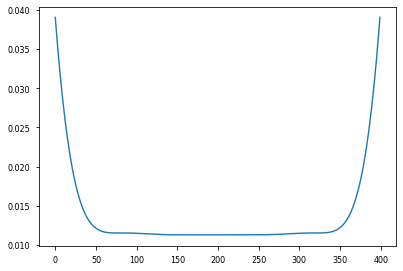

In [15]:
plt.plot(var_y.squeeze())

In [16]:
test_X.shape, mu_y.shape

((1,), (400, 1))

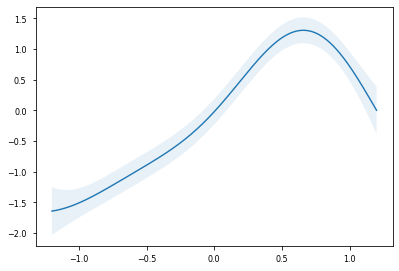

In [17]:
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())

plt.fill_between(Xtest.squeeze(), mu_y.squeeze() + uncertainty, mu_y.squeeze() - uncertainty, alpha=0.1)
plt.plot(Xtest.squeeze(), mu_y.squeeze(), label='Mean')

## 5. Loss - Log-Likelihood

### From Scratch

In [18]:

# @jax.jit
def cholesky_factorization(K, Y):
    
    # cho factor the cholesky 
    L = jax.scipy.linalg.cho_factor(K)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)
    
    return L, weights

def nll_scratch(gp_priors, params, X, Y) -> float:
    
    (mu_func, cov_func) = gp_priors
    
    # ==========================
    # 1. GP PRIOR
    # ==========================
    mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func , x=X)
#     y_mean = jnp.mean(Y, axis=1)
#     Y -= y_mean
#     print(mu_x.shape, Kxx.shape)
    
    # ===========================
    # 2. CHOLESKY FACTORIZATION
    # ===========================
#     print(f"Problem:", X.shape, Y.shape, Kxx.shape)
#     print(f"Y: {Y.shape}, Kxx: {Kxx.shape}")
    
    (L, lower), alpha = cholesky_factorization(Kxx + ( params['likelihood_noise'] + 1e-5 ) * jnp.eye(Kxx.shape[0]), Y)
#     L = jax.scipy.linalg.cholesky(Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0]), lower=True)
#     alpha = jax.scipy.linalg.solve_triangular(L.T, jax.scipy.linalg.solve_triangular(L, y, lower=True))
#     print(f"Y: {Y.shape}, alpha: {alpha.shape}")
    logging.debug(f"Y: {Y.shape},alpha:{alpha.shape}")
    log_likelihood = -0.5 * jnp.einsum("ik,ik->k", Y, alpha) #* jnp.dot(Y.T, alpha) #
    log_likelihood -= jnp.sum(jnp.log(jnp.diag(L)))
    log_likelihood -= ( Kxx.shape[0] / 2 ) * jnp.log(2 * jnp.pi)
#     log_likelihood -= jnp.sum(-0.5 * np.log(2 * 3.1415) - params['var_f']**2)
    return - jnp.sum(log_likelihood)
# #     print(L.shape, alpha.shape)
#     # cho factor the cholesky 
#     K_gp = Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0])
# #     L = jax.scipy.linalg.cholesky(K_gp)
# #     assert np.testing.assert_array_almost_equal(K_gp, L @ L.T), 
    
#     return jax.scipy.stats.multivariate_normal.logpdf(Y, mean=mu_x, cov=K_gp)

In [19]:
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'gamma': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.01,
}
cov_f = functools.partial(gram, rbf_kernel)


prior_funcs = (mu_f, cov_f)
# print(X.shape, y.shape, test_X.shape)

nll = nll_scratch(prior_funcs, params, X, y)
print(nll)

DEBUG:absl:Compiling _cholesky for args (ShapedArray(float32[30,30]),).
DEBUG:absl:Compiling _cho_solve for args (ShapedArray(float32[30,30]), ShapedArray(float32[30,1])).
DEBUG:root:Y: (30, 1),alpha:(30, 1)
DEBUG:absl:Compiling _einsum for args (ShapedArray(float32[30,1]), ShapedArray(float32[30,1])).
DEBUG:absl:Compiling _where for args (ShapedArray(bool[30,30]), ShapedArray(float32[30,30]), ShapedArray(float32[30,30])).


54.878708


#### Auto-Batching with VMAP

In [234]:
nll_scratch_vec = jax.vmap(nll_scratch, in_axes=(None, None, 0, 0))

nll = nll_scratch_vec(params, prior_funcs, X, y[:, None])
print(nll.sum())


(1,) (1, 1)
Y: (1,), alpha: (1,)
-209.98637


### Refactor - Built-in Function

It turns out that the jax library already has the `logpdf` for the `multivariate_normal` already implemented. So we can just use that.

In [20]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)

def marginal_likelihood(prior_params, params,  Xtrain, Ytrain):
    
    # unpack params
    (mu_func, cov_func) = prior_params
    
    # ==========================
    # 1. GP Prior
    # ==========================
    mu_x = mu_f(Xtrain)
    logging.debug(f"mu: {mu_x.shape}")
    Kxx = cov_f(params, Xtrain, Xtrain)
    logging.debug(f"Kxx: {Kxx.shape}")
#     print("MLL (GPPR):", Xtrain.shape, Ytrain.shape)
#     mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func , x=Xtrain)
    
    # ===========================
    # 2. GP Likelihood
    # ===========================
    K_gp = Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0])
    logging.debug(f"K_gp: {K_gp.shape}")
#     print("MLL (GPLL):", Xtrain.shape, Ytrain.shape)
    
    # ===========================
    # 3. Built-in GP Likelihood
    # ===========================
    logging.debug(f"Input: {Ytrain.squeeze().shape}, mu: {mu_x.shape}, K: {K_gp.shape}")
    log_prob = jax.scipy.stats.multivariate_normal.logpdf(Ytrain.squeeze(), mean=jnp.zeros(Ytrain.shape[0]), cov=K_gp)
    logging.debug(f"LogProb: {log_prob.shape}")
    
    nll = jnp.sum(log_prob)
    return -nll
    
            
    




In [21]:
logger.setLevel(logging.DEBUG)
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'gamma': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.01,
}
cov_f = functools.partial(gram, rbf_kernel)


prior_funcs = (mu_f, cov_f)
# print(X.shape, y.shape, test_X.shape)

nll = marginal_likelihood(prior_funcs, params, X, y)
print(nll)

DEBUG:root:mu: (30,)
DEBUG:root:Kxx: (30, 30)
DEBUG:root:K_gp: (30, 30)
DEBUG:root:Input: (30,), mu: (30,), K: (30, 30)
DEBUG:absl:Compiling _einsum for args (ShapedArray(float32[30]), ShapedArray(float32[30])).
DEBUG:root:LogProb: ()


54.937344


In [22]:
logger.setLevel(logging.INFO)
%timeit _ = nll_scratch(prior_funcs, params, X, y)
%timeit _ = marginal_likelihood(prior_funcs, params, X, y)

18.3 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
26 ms ± 906 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 6. Training

In [23]:
def softplus(x):
    return np.logaddexp(x, 0.)

In [24]:
logger.setLevel(logging.INFO)

X, y, Xtest, ytest = get_data(30)



params = {
    'gamma': 10.,
#     'length_scale': 1.0,
#     'var_f': 1.0,
    'likelihood_noise': 1e-3,
}

# Nice Trick for better training of params
def saturate(params):
    return {ikey:softplus(ivalue) for (ikey, ivalue) in params.items()}

params = saturate(params)

cov_f = functools.partial(gram, rbf_kernel)

gp_priors = (mu_f, cov_f)

# LOSS FUNCTION
mll_loss = jax.jit(functools.partial(nll_scratch, gp_priors))

# GRADIENT LOSS FUNCTION
dloss = jax.jit(jax.grad(mll_loss))



# MEAN FUNCTION
mu_f = zero_mean


# l_val = mll_loss(saturate(params), X[0,:], y[0, :].reshape(-1, 1))
l_vals = mll_loss(saturate(params), X, y)
# print('MLL (vector):', l_val)
# print('MLL (samples):', l_vals)


# dl_val = dloss(saturate(params), X[0,:], y[0, :].reshape(-1, 1))
dl_vals = dloss(saturate(params), X, y)
# print('dMLL (vector):', dl_val)|
# print('dMLL (samples):', dl_vals)



# STEP FUNCTION
@jax.jit
def step(params, X, y, opt_state):
    # print("BEOFRE!")
    # print(X.shape, y.shape)
    # print("PARAMS", params)
    # print(opt_state)
    # value and gradient of loss function
    loss = mll_loss(params, X, y)
    grads = dloss(params, X, y)
    # # print(f"VALUE:", value)
    # print("During! v", value)
    # print("During! p", params)
    # print("During! g", grads)
    # update parameter state
    opt_state = opt_update(0, grads, opt_state)

    # get new params
    params = get_params(opt_state)
    # print("AFTER! v", value)
    # print("AFTER! p", params)
    # print("AFTER! g", grads)
    return params, opt_state, loss

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)

# initialize parameters
opt_state = opt_init(params)

# get initial parameters
params = get_params(opt_state)
# print("PARAMS!", params)

n_epochs = 2_000
learning_rate = 0.01
losses = list()

import tqdm

with tqdm.trange(n_epochs) as bar:

    for i in bar:
        postfix = {}
#         params = saturate(params)
        # get nll and grads
        # nll, grads = dloss(params, X, y)

        params, opt_state, value = step(params, X, y, opt_state)

        # update params
        # params, momentums, scales, nll = train_step(params, momentums, scales, X, y)
        for ikey in params.keys():
            postfix[ikey] = f"{params[ikey]:.2f}"
        # params[ikey] += learning_rate * grads[ikey].mean()

        losses.append(value.mean())
        postfix["Loss"] = f"{onp.array(losses[-1]):.2f}"
        bar.set_postfix(postfix)
        params = saturate(params)
        

# params = log_params(params)

100%|██████████| 2000/2000 [00:05<00:00, 335.90it/s, gamma=1.58, likelihood_noise=-2.76, Loss=10.66]


{'gamma': 1.770868627016222, 'likelihood_noise': 0.06155753105145977}

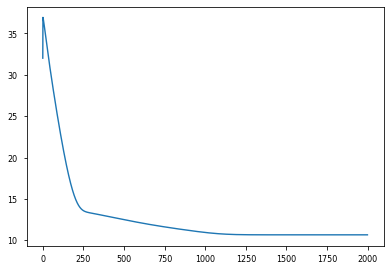

In [25]:
plt.plot(losses)
params

## 7. Predictions

In [26]:
def posterior(params, prior_params, X, Y, X_new, likelihood_noise=False):
    logging.debug(f"Inputs, X: {X.shape}, Y: {Y.shape}, X*: {X_new.shape}")
    (mu_func, cov_func) = prior_params
    logging.debug("Loaded mean and cov functions")

    # ==========================
    # 1. GP PRIOR
    # ==========================
    logging.debug(f"Getting GP Priors...")
    
    mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func, x=X)
    logging.debug(f"Output, mu_x: {mu_x.shape}, Kxx: {Kxx.shape}")
    logging.debug(f"Output, Kxx: {Kxx.shape}, {Kxx.min()}, {Kxx.max()}")
    # check outputs
    assert mu_x.shape == (X.shape[0],), f"{mu_x.shape} =/= {(X.shape[0],)}"
    assert Kxx.shape == (
        X.shape[0],
        X.shape[0],
    ), f"{Kxx.shape} =/= {(X.shape[0],X.shape[0])}"

    # ===========================
    # 2. CHOLESKY FACTORIZATION
    # ===========================
    logging.debug(f"Solving Cholesky Factorization...")

    # 1 STEP
#     print(f"Problem: {Kxx.shape},{Y.shape}")
    L = jax.scipy.linalg.cholesky(
        Kxx + (params["likelihood_noise"] + 1e-7) * jnp.eye(Kxx.shape[0]), lower=True
    )
    logging.debug(f"Output, L: {L.shape},{L.min()},{L.max()} ")
    
    alpha = jax.scipy.linalg.solve_triangular(
        L.T, 
        jax.scipy.linalg.solve_triangular(L, Y, lower=True)
    )
#     (L, lower), alpha = cholesky_factorization(
#         , Y
#     )
    logging.debug(f"Output, L: {L.shape}, alpha: {alpha.shape},{alpha.min()},{alpha.max()} ")
    assert L.shape == (
        X.shape[0],
        X.shape[0],
    ), f"L:{L.shape} =/= X..:{(X.shape[0],X.shape[0])}"
    assert alpha.shape == (X.shape[0], 1), f"alpha: {alpha.shape} =/= X: {X.shape[0], 1}"

    # ================================
    # 4. PREDICTIVE MEAN DISTRIBUTION
    # ================================
    logging.debug(f"Getting Projection Kernel...")
    logging.debug(f"Input, cov(x*, X): {X_new.shape},{X.shape}")

    # calculate transform kernel
    KxX = cov_func(params, X_new, X)
    
    logging.debug(f"Output, KxX: {KxX.shape}")
    

    assert KxX.shape == (
        X_new.shape[0],
        X.shape[0],
    ), f"{KxX.shape} =/= {(X_new.shape[0],X.shape[0])}"

    # Project data
    logging.debug(f"Getting Predictive Mean Distribution...")
    logging.debug(f"Input, mu(x*): {X_new.shape}, KxX @ alpha: {KxX.shape} @ {alpha.shape}")
    mu_y = jnp.dot(KxX, alpha)
    logging.debug(f"Output, mu_y: {mu_y.shape}")
    assert mu_y.shape == (X_new.shape[0],1)

    # =====================================
    # 5. PREDICTIVE COVARIANCE DISTRIBUTION
    # =====================================
    logging.debug(f"Getting Predictive Covariance matrix...")
    logging.debug(f"Input, L @ KxX.T: {L.shape} @ {KxX.T.shape}")
    
    #     print(f"K_xX: {KXx.T.shape}, L: {L.shape}")
    v = jax.scipy.linalg.cho_solve((L, True), KxX.T)

    logging.debug(f"Output, v: {v.shape}, {v.min():.2f},{v.max():.2f}")
    assert v.shape == (
        X.shape[0],
        X_new.shape[0],
    ), f"v: {v.shape} =/= {(X_new.shape[0])}"
    
    logging.debug(f"Covariance matrix tests...cov(x*, x*)")
    logging.debug(f"Inputs, cov(x*, x*) - {X_new.shape},{X_new.shape}")
    Kxx = cov_func(params, X_new, X_new)
    
    logging.debug(f"Output, Kxx: {Kxx.shape}")
    assert Kxx.shape == (X_new.shape[0], X_new.shape[0])
    
    logging.debug(f"Calculating final covariance matrix...")
    logging.debug(f"Inputs, Kxx: {Kxx.shape}, v:{v.shape}")
    
    cov_y = Kxx - jnp.dot(KxX, v)
    logging.debug(f"Output: cov(x*, x*) - {cov_y.shape}")

    assert cov_y.shape == (X_new.shape[0], X_new.shape[0])
    
    if likelihood_noise is True:
        cov_y += params['likelihood_noise']

    # TODO: Bug here for vmap...

    # =====================================
    # 6. PREDICTIVE VARIANCE DISTRIBUTION
    # =====================================
    logging.debug(f"Getting Predictive Variance...")
    logging.debug(f"Input, L.T, I: {L.T.shape}, {KxX.T.shape}")
    
    Linv = jax.scipy.linalg.solve_triangular(L.T, jnp.eye(L.shape[0]))
    
    
    logging.debug(f"Output, Linv: {Linv.shape}, {Linv.min():.2f},{Linv.max():.2f}")

    logging.debug(f"Covariance matrix tests...cov(x*, x*)")
    logging.debug(f"Inputs, cov(x*, x*) - {X_new.shape},{X_new.shape}")
    var_y = jnp.diag(cov_func(params, X_new, X_new))
    logging.debug(f"Output, diag(Kxx): {var_y.shape}, {var_y.min():.2f},{var_y.max():.2f}")
    
    logging.debug(f"Inputs, Linv @ Linv.T - {Linv.shape},{Linv.T.shape}")
    Kinv =  jnp.dot(Linv, Linv.T)
    logging.debug(f"Output, Kinv: {Kinv.shape}, {Kinv.min():.2f},{Kinv.max():.2f}")
    
    logging.debug(f"Final Variance...")
    logging.debug(f"Inputs, KxX: {KxX.shape}, {Kinv.shape}, {KxX.shape}")
    var_y -= jnp.einsum("ij,ij->i", jnp.dot(KxX, Kinv), KxX) #jnp.dot(jnp.dot(KxX, Kinv), KxX.T)
    logging.debug(f"Output, var_y: {var_y.shape}, {var_y.min():.2f},{var_y.max():.2f}")
    #jnp.einsum("ij, jk, ki->i", KxX, jnp.dot(Linv, Linv.T), KxX.T)

    return mu_y, cov_y, jnp.diag(cov_y)

In [27]:
params

{'gamma': 1.770868627016222, 'likelihood_noise': 0.06155753105145977}

In [28]:
# print(X.shape, y.shape, test_X.shape)
logger.setLevel(logging.DEBUG)
# x_plot = jnp.linspace(X.min(), X.max(), 1_000)[:, None]
print(X.shape, y.shape, Xtest.shape)
mu_y, cov_y, var_y = posterior(params, gp_priors, X, y, Xtest, True)

print(mu_y.shape, cov_y.shape, var_y.shape)
# onp.testing.assert_array_almost_equal(jncov_y, var_y)

DEBUG:root:Inputs, X: (30, 1), Y: (30, 1), X*: (400, 1)
DEBUG:root:Loaded mean and cov functions
DEBUG:root:Getting GP Priors...
DEBUG:absl:Compiling rbf_kernel for args (ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[30,1]), ShapedArray(float32[30,1])).


(30, 1) (30, 1) (400, 1)


DEBUG:root:Output, mu_x: (30,), Kxx: (30, 30)
DEBUG:root:Output, Kxx: (30, 30), 0.000838853360619396, 1.0
DEBUG:root:Solving Cholesky Factorization...
DEBUG:root:Output, L: (30, 30),0.0,1.0303192138671875 
DEBUG:absl:Compiling _solve_triangular for args (ShapedArray(float32[30,30]), ShapedArray(float32[30,1])).
DEBUG:absl:Compiling _solve_triangular for args (ShapedArray(float32[30,30]), ShapedArray(float32[30,1])).
DEBUG:root:Output, L: (30, 30), alpha: (30, 1),-8.470149993896484,10.187272071838379 
DEBUG:root:Getting Projection Kernel...
DEBUG:root:Input, cov(x*, X): (400, 1),(30, 1)
DEBUG:absl:Compiling rbf_kernel for args (ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[400,1]), ShapedArray(float32[30,1])).
DEBUG:root:Output, KxX: (400, 30)
DEBUG:root:Getting Predictive Mean Distribution...
DEBUG:root:Input, mu(x*): (400, 1), KxX @ alpha: (400, 30) @ (30, 1)
DEBUG:root:Output, mu_y: (400, 1)
DEBUG:root:Getting Predictive Covariance matrix...
DEBUG:root:Input, L 

(400, 1) (400, 400) (400,)


0.07021278 0.18080568 0.05092573 0.18080568


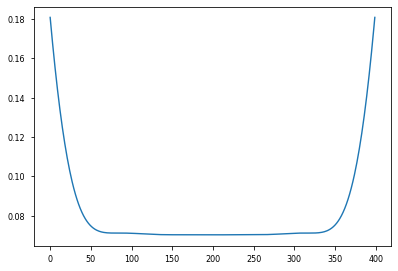

In [29]:
print(var_y.min(), var_y.max(), cov_y.min(), cov_y.max())
plt.plot(var_y.squeeze())

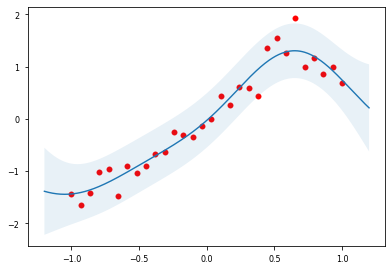

In [30]:
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())


fig, ax = plt.subplots()
ax.scatter(X, y, c='red')
plt.plot(Xtest.squeeze(), mu_y.squeeze(), label='Mean')
plt.fill_between(Xtest.squeeze(), mu_y.squeeze() + uncertainty, mu_y.squeeze() - uncertainty, alpha=0.1)
plt.show()